<a href="https://colab.research.google.com/github/TurkuNLP/intro-to-nlp/blob/master/nn_bow_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bag-of-words document classification

* BoW is the simplest way to do classification: Feature vector goes in, decision falls out.

* Feature vector: a vector with as many dimensions as we have unique features, and a non-zero value set for every feature present in our example
* Binary features: 1/0

In the following we work with the IMDB data, have a look on [how to read it in](read_imdb.ipynb). Here we just read the ready data in.

# IMDB data

* Familiar data
* Input vectorized as before
* But now we will also have to turn class labels into integers and back explicitly so we can use Keras


In [1]:
!wget -nc https://github.com/TurkuNLP/intro-to-nlp/raw/master/Data/imdb_train.json

--2021-01-13 10:38:40--  https://github.com/TurkuNLP/intro-to-nlp/raw/master/Data/imdb_train.json
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TurkuNLP/intro-to-nlp/master/Data/imdb_train.json [following]
--2021-01-13 10:38:40--  https://raw.githubusercontent.com/TurkuNLP/intro-to-nlp/master/Data/imdb_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33944099 (32M) [text/plain]
Saving to: ‘imdb_train.json’

imdb_train.json     100%[===================>]  32.37M  --.-KB/s    in 0.1s    

2021-01-13 10:38:41 (270 MB/s) - ‘imdb_train.json’ saved [33944099/33944099]



In [2]:
import json
import random
with open("imdb_train.json") as f:
    data=json.load(f)
random.shuffle(data) #play it safe!

texts=[one_example["text"] for one_example in data]
labels=[one_example["class"] for one_example in data]


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

train_texts, dev_texts, train_labels, dev_labels=train_test_split(texts,labels,test_size=0.2)
vectorizer=CountVectorizer(max_features=100000,binary=True,ngram_range=(1,1))
feature_matrix_train=vectorizer.fit_transform(train_texts)
feature_matrix_dev=vectorizer.transform(dev_texts)

print("shape=",feature_matrix_train.shape)


shape= (20000, 68351)


In [4]:
import tensorflow as tf
import numpy as np

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

feature_matrix_train_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_train)
feature_matrix_dev_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_dev)

Now we have the feature matrix done! Next thing we need is the class labels:

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder() #Turns class labels into integers
class_numbers_train=label_encoder.fit_transform(train_labels)
class_numbers_dev=label_encoder.transform(dev_labels)

print("class_numbers shape=",class_numbers_train.shape)
print("class labels",label_encoder.classes_) #this will let us translate back from indices to labels

class_numbers shape= (20000,)
class labels ['neg' 'pos']


* The data is ready :)

We need to build the network now
* Input
* Hidden Dense layer with some kind of non-linearity, and a suitable number of nodes
* Output Dense layer with the softmax activation (normalizes output to distribution) and as many nodes as there are classes

In [6]:
from keras.models import Model
from keras.layers import Input, Dense

example_count,feature_count=feature_matrix_train.shape #how many examples and features we've got?
example_count2=class_numbers_train.shape[0]
assert example_count==example_count2 #sanity check
class_count=len(label_encoder.classes_) #How many classes we've got?

#Build the network:
inp=Input(shape=(feature_count,)) #Input layer
hidden=Dense(200,activation="tanh")(inp) #Hidden layer
outp=Dense(class_count,activation="softmax")(hidden) #Output layer
model=Model(inputs=[inp], outputs=[outp])

...it's **this** simple...!

Once the model is constructed it needs to be compiled, for that we need to know:
* which optimizer we want to use (sgd is fine to begin with)
* what is the loss (sparse_categorial_crossentropy for multiclass of the kind we have is the right choice)
* which metrics to measure, accuracy is an okay choice

In [7]:
model.compile(optimizer="sgd",loss="sparse_categorical_crossentropy",metrics=['accuracy'])

A compiled model can be fitted on data:

In [8]:


hist=model.fit(feature_matrix_train_tf,class_numbers_train,\
               validation_data=(feature_matrix_dev_tf,class_numbers_dev),\
               batch_size=100,verbose=1,epochs=10)

Epoch 1/10
200/200 [==============================] - 3s 6ms/step - loss: 0.6183 - accuracy: 0.7088 - val_loss: 0.4855 - val_accuracy: 0.8180
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4534 - accuracy: 0.8340 - val_loss: 0.4134 - val_accuracy: 0.8406
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3892 - accuracy: 0.8513 - val_loss: 0.3779 - val_accuracy: 0.8518
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3502 - accuracy: 0.8633 - val_loss: 0.3563 - val_accuracy: 0.8594
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3225 - accuracy: 0.8775 - val_loss: 0.3418 - val_accuracy: 0.8638
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3086 - accuracy: 0.8812 - val_loss: 0.3308 - val_accuracy: 0.8690
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2905 - accuracy: 0.8869 - val_loss: 0.3213 - val_accuracy: 0.8730
Epoch 

In [9]:
print(hist.history["val_accuracy"])

[0.8180000185966492, 0.8406000137329102, 0.8518000245094299, 0.8593999743461609, 0.8637999892234802, 0.8690000176429749, 0.8730000257492065, 0.8772000074386597, 0.8762000203132629, 0.878000020980835]


* We ran for 10 epochs of training
* Made it to a decent accuracy on the validation data

* But we do not have the model saved, so let's fix that and get the whole thing done
* What constitutes a model (ie what we need to run the model on new data)
  - The feature dictionary in the vectorizer
  - The list of classes in their correct order
  - The structure of the network
  - The weights the network learned

* Do all these things, and run again. This time we also increase the number of epochs, see what happens.

In [10]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
import os
import pickle

def save_model(file_name,model,label_encoder,vectorizer):
    """Saves model structure and vocabularies"""
    model_json = model.to_json()
    with open(file_name+".model.json", "w") as f:
        print(model_json,file=f)
    with open(file_name+".encoders.pickle","wb") as f:
        pickle.dump((label_encoder,vectorizer),f)
            
example_count,feature_count=feature_matrix_train_tf.shape #how many examples and features we've got?
example_count2=class_numbers_train.shape[0]
assert example_count==example_count2 #sanity check
class_count=len(label_encoder.classes_) #How many classes we've got?

#Build the network:
inp=Input(shape=(feature_count,)) #Input layer
hidden=Dense(200,activation="tanh")(inp) #Hidden layer
outp=Dense(class_count,activation="softmax")(hidden) #Output layer
model=Model(inputs=[inp], outputs=[outp])

# Let's try a different optimizer!
opt=optimizers.Adam()
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

# Save model and vocabularies, can be done before training
os.makedirs("models",exist_ok=True)
save_model("models/imdb_bow",model,label_encoder,vectorizer)
# Callback function to save weights during training, if validation loss goes down
save_cb=ModelCheckpoint(filepath="models/imdb_bow.weights.h5", monitor='val_loss',\
                        verbose=1, save_best_only=True, mode='auto')
stop_cb=EarlyStopping(patience=2,verbose=1,restore_best_weights=True)
hist=model.fit(feature_matrix_train_tf,class_numbers_train,\
               validation_data=(feature_matrix_dev_tf,class_numbers_dev),\
               batch_size=100,verbose=1,epochs=20,\
               callbacks=[save_cb,stop_cb])


Epoch 1/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3956 - accuracy: 0.8175 - val_loss: 0.2754 - val_accuracy: 0.8924

Epoch 00001: val_loss improved from inf to 0.27541, saving model to models/imdb_bow.weights.h5
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0836 - accuracy: 0.9745 - val_loss: 0.3892 - val_accuracy: 0.8768

Epoch 00002: val_loss did not improve from 0.27541
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0300 - accuracy: 0.9915 - val_loss: 0.5764 - val_accuracy: 0.8694

Epoch 00003: val_loss did not improve from 0.27541
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


In [11]:
import numpy
from sklearn.metrics import classification_report, confusion_matrix

#Validation data used during training:
val_instances,val_labels=feature_matrix_dev_tf,class_numbers_dev

print("Network output=",model.predict(val_instances))
predictions=numpy.argmax(model.predict(val_instances),axis=1)
print("Maximum class for each example=",predictions)
gold=val_labels
conf_matrix=confusion_matrix(list(gold),list(predictions))
print("Confusion matrix=\n",conf_matrix)

gold_labels=label_encoder.inverse_transform(list(gold))
predicted_labels=label_encoder.inverse_transform(list(predictions))
#print("Gold labels=",gold_labels)
#print("Predicted labels=",predicted_labels)
print(classification_report(gold_labels,predicted_labels))


Network output= [[1.38831441e-03 9.98611689e-01]
 [7.69110769e-03 9.92308855e-01]
 [4.05633152e-02 9.59436655e-01]
 ...
 [7.77789950e-02 9.22221005e-01]
 [5.65217575e-04 9.99434769e-01]
 [8.76782894e-01 1.23217165e-01]]
Maximum class for each example= [1 1 1 ... 1 1 0]
Confusion matrix=
 [[2229  276]
 [ 262 2233]]
              precision    recall  f1-score   support

         neg       0.89      0.89      0.89      2505
         pos       0.89      0.89      0.89      2495

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



# Learning progress

* The history object we get lets us inspect the accuracy during training
* Remarks:
  - Accuracy on training data keeps going up
  - Accuracy on validation (test) data flattens out after a but over 10 epochs, we are learning very little past that point
  - What we see is the network keeps overfitting on the training data to the end

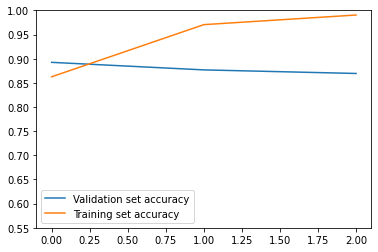

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.ylim(0.55,1.0)
plt.plot(hist.history["val_accuracy"],label="Validation set accuracy")
plt.plot(hist.history["accuracy"],label="Training set accuracy")
plt.legend()
plt.show()

# Summary

* We put together a program to train a neural network classifier for sentiment detector
* We learned the necessary code/techniques to save models, and feed the training with data in just the right format
* We observed the training across epochs
* We saw how the classifier can be applied to various text classification problems
* The IMDB sentiment classifier ended up at nearly 90% accuracy, the state of the art is about 95%, we got surprisingly far in few lines of code


# Save models in drive

* The model is quite large, if you want to use it elsewhere, it makes sense to save it in Google Drive
* Press "Mount Drive" under "Files" in top left corner and follow the instructions
* Your drive will be mounted under /content/drive/MyDrive and you can then share the models across notebooks

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
!mkdir -p /content/drive/MyDrive/intro-to-nlp/models-2021
save_model("/content/drive/MyDrive/intro-to-nlp/models-2021/imdb_bow",model,label_encoder,vectorizer)
#and yet the weights!
model.save("/content/drive/MyDrive/intro-to-nlp/models-2021/imdb_bow.weights.h5")